In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
from transformers import ViTFeatureExtractor

model_ckpt = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [3]:
images_root = 'Affectnet/Manually_Annotated/Manually_Annotated_Images'

In [4]:
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import os


def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class AffectNetDataset(Dataset):
    def __init__(self,
                 csvfile,
                 root,
                 mode='classification',
                 crop=False,
                 transform=None,
                 invalid_files=None):
        assert mode in ('valence', 'arousal', 'valence-arousal')
        self.df = pd.read_csv(csvfile)
        self.root = root
        self.mode = mode
        self.crop = crop
        self.transform = transform
        self.invalid_files = invalid_files
        
        if self.invalid_files:
            self.df = self.df[~self.df['subDirectory_filePath'].isin(invalid_files)]
            self.df = self.df
        
        self.df = self.df[~((self.df['expression'] == 9) | (self.df['expression'] == 10))].reset_index(drop=True)
    
    def __getitem__(self, idx):
        try:
            img = pil_loader(os.path.join(self.root, self.df['subDirectory_filePath'][idx]))
        except KeyError:
            raise IndexError
        if self.crop:
            img = img.crop((self.df['face_x'][idx],
                            self.df['face_y'][idx],
                            self.df['face_x'][idx]+self.df['face_width'][idx],
                            self.df['face_y'][idx]+self.df['face_height'][idx],))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'classification':
            target = torch.tensor(self.df['expression'][idx])
        elif self.mode == 'valence':
            target = torch.tensor([self.df['valence'][idx]])
        elif self.mode == 'arousal':
            target = torch.tensor([self.df['arousal'][idx]])
        else:
            target = torch.tensor([self.df['valence'][idx],
                                   self.df['arousal'][idx]])
        return img.float(), target.float()
    
    def __len__(self):
        return len(self.df)

In [5]:
def collate_fn(examples):
    imgs, targets = zip(*examples)
    pixel_values = torch.stack(imgs)
    targets = torch.stack(targets)
    return {'pixel_values': pixel_values, 'labels': targets}

In [6]:
train_invalid_files = ['103/29a31ebf1567693f4644c8ba3476ca9a72ee07fe67a5860d98707a0a.jpg']
val_invalid_files = []

In [7]:
mode = 'arousal'
seed = 0

In [8]:
from torchvision.transforms import (Compose,
                                    Normalize,
                                    Resize,
                                    ToTensor)
from torch.utils.data import random_split


normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

transform = Compose([Resize(tuple(feature_extractor.size.values())),
                     ToTensor()])

train_dataset = AffectNetDataset('Affectnet/training.csv',
                                 images_root,
                                 mode,
                                 crop=False,
                                 transform=transform,
                                 invalid_files=train_invalid_files)

val_dataset = AffectNetDataset('Affectnet/validation.csv',
                               images_root,
                               mode,
                               crop=False,
                               transform=transform,
                               invalid_files=val_invalid_files)

print('train:', len(train_dataset))
print('validation:', len(val_dataset))


train: 320739
validation: 4500


訓練データの分布をカーネル密度推定により平滑化し，MSEに重みづけする

In [9]:
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.modules.loss import _Loss
from scipy.stats import gaussian_kde

class KDEWeightLoss(_Loss):
    def __init__(self, dataset, mode, bw_method=None, eps=1e-6, device=None):
        super(KDEWeightLoss, self).__init__()
        assert mode in ('valence', 'arousal', 'valence-arousal')
        self.mode = mode
        self.bw_method = bw_method
        self.eps = eps
        self.device = device
        self.kernel = self._calc_kernel(dataset.df)
    
    def forward(self, pred, target):
        loss = torch.mean(torch.dot(torch.tensor(1 / (self.kernel(target.cpu().T) + self.eps)).float().to(self.device),
                                    ((pred - target) ** 2).sum(1)))
        return loss
    
    def _calc_kernel(self, df):
        if self.mode == 'arousal':
            data = df[self.mode].to_numpy().T
        elif self.mode == 'valence':
            data = df[self.mode].to_numpy().T
        else:
            data = df[['valence', 'arousal']].to_numpy().T
        return gaussian_kde(data, bw_method=self.bw_method)

In [10]:
from transformers import Trainer
import wandb

class KDEWeightLossTrainer(Trainer):
    def __init__(self,
                 model = None,
                 args = None,
                 data_collator = None,
                 train_dataset = None,
                 eval_dataset = None,
                 tokenizer = None,
                 model_init = None,
                 compute_metrics = None,
                 callbacks = None,
                 optimizers = (None, None),
                 preprocess_logits_for_metrics = None):
        super().__init__(model, args, data_collator, train_dataset, eval_dataset, tokenizer, model_init, compute_metrics, callbacks, optimizers, preprocess_logits_for_metrics)
        self.loss_fct = KDEWeightLoss(dataset=train_dataset,
                                      mode=mode,
                                      bw_method=0.2,
                                      device=self.args.device).to(self.args.device)
        self.mse = nn.MSELoss()
    
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss = self.loss_fct(logits, labels)
        mse = self.mse(logits, labels)
        rmse = torch.sqrt(mse)
        wandb.log({'train/mse': mse, 'train/rmse': rmse})
        return (loss, outputs) if return_outputs else loss

In [11]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=1,
                                                  problem_type='regression')


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
from transformers import TrainingArguments
import wandb

wandb.init(project='AffectNet-vit', name='KDE-aro', id='kde_aro_230404')

args = TrainingArguments(
    f"affectnet-kde-aro",
    evaluation_strategy="steps",
    eval_steps=1000,
    save_strategy='steps',
    save_steps=1000,
    learning_rate=1e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=30,
    weight_decay=1e-3,
    load_best_model_at_end=True,
    logging_dir='logs',
    remove_unused_columns=False,
    report_to='wandb'
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rkn. Use `wandb login --relogin` to force relogin


In [13]:
from sklearn.metrics import mean_squared_error
import numpy as np

def compute_metrics(eval_pred):
    preds, targets = eval_pred
    mse = mean_squared_error(targets, preds, squared=True) / 2
    rmse = np.sqrt(mse)
    return {'mse': mse, 'rmse': rmse}

In [14]:
from transformers import EarlyStoppingCallback

trainer = KDEWeightLossTrainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=4, early_stopping_threshold=0.005)]
)

In [15]:
trainer.train()

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 500/300720 [09:06<89:46:27,  1.08s/it] 

{'loss': 18.8986, 'learning_rate': 9.98337323756318e-07, 'epoch': 0.05}


  0%|          | 1000/300720 [17:59<87:30:43,  1.05s/it]

{'loss': 18.6914, 'learning_rate': 9.966746475126364e-07, 'epoch': 0.1}


                                                        
  0%|          | 1000/300720 [19:51<87:30:43,  1.05s/it]

{'eval_loss': 14.185880661010742, 'eval_mse': 0.0935685932636261, 'eval_rmse': 0.3058898384445389, 'eval_runtime': 111.8452, 'eval_samples_per_second': 40.234, 'eval_steps_per_second': 2.521, 'epoch': 0.1}


  0%|          | 1500/300720 [28:57<88:07:07,  1.06s/it]  

{'loss': 17.2063, 'learning_rate': 9.950119712689545e-07, 'epoch': 0.15}


  1%|          | 2000/300720 [37:47<84:14:30,  1.02s/it]

{'loss': 16.3374, 'learning_rate': 9.933492950252726e-07, 'epoch': 0.2}


                                                        
  1%|          | 2000/300720 [38:35<84:14:30,  1.02s/it]

{'eval_loss': 13.34114933013916, 'eval_mse': 0.09759934991598129, 'eval_rmse': 0.31240894660041557, 'eval_runtime': 47.3933, 'eval_samples_per_second': 94.95, 'eval_steps_per_second': 5.95, 'epoch': 0.2}


  1%|          | 2500/300720 [47:35<82:32:12,  1.00it/s]  

{'loss': 15.325, 'learning_rate': 9.916866187815907e-07, 'epoch': 0.25}


  1%|          | 3000/300720 [56:25<91:48:57,  1.11s/it] 

{'loss': 15.2187, 'learning_rate': 9.90023942537909e-07, 'epoch': 0.3}


                                                        
  1%|          | 3000/300720 [58:08<91:48:57,  1.11s/it]

{'eval_loss': 12.488321304321289, 'eval_mse': 0.09543497115373611, 'eval_rmse': 0.30892551068782925, 'eval_runtime': 102.5196, 'eval_samples_per_second': 43.894, 'eval_steps_per_second': 2.751, 'epoch': 0.3}


  1%|          | 3500/300720 [1:07:09<88:53:35,  1.08s/it] 

{'loss': 13.4985, 'learning_rate': 9.88361266294227e-07, 'epoch': 0.35}


  1%|▏         | 4000/300720 [1:16:07<89:18:30,  1.08s/it] 

{'loss': 13.9573, 'learning_rate': 9.866985900505454e-07, 'epoch': 0.4}


                                                          
  1%|▏         | 4000/300720 [1:16:53<89:18:30,  1.08s/it]

{'eval_loss': 11.240557670593262, 'eval_mse': 0.0856831967830658, 'eval_rmse': 0.2927169226113615, 'eval_runtime': 46.4923, 'eval_samples_per_second': 96.79, 'eval_steps_per_second': 6.066, 'epoch': 0.4}


  1%|▏         | 4500/300720 [1:26:01<92:00:23,  1.12s/it]  

{'loss': 13.9251, 'learning_rate': 9.850359138068635e-07, 'epoch': 0.45}


  2%|▏         | 5000/300720 [1:34:48<86:00:36,  1.05s/it]

{'loss': 12.597, 'learning_rate': 9.833732375631816e-07, 'epoch': 0.5}


                                                          
  2%|▏         | 5000/300720 [1:35:34<86:00:36,  1.05s/it]

{'eval_loss': 11.314952850341797, 'eval_mse': 0.0891704261302948, 'eval_rmse': 0.29861417603706425, 'eval_runtime': 46.3403, 'eval_samples_per_second': 97.108, 'eval_steps_per_second': 6.085, 'epoch': 0.5}


  2%|▏         | 5500/300720 [1:44:31<85:52:36,  1.05s/it]  

{'loss': 12.7263, 'learning_rate': 9.817105613194997e-07, 'epoch': 0.55}


  2%|▏         | 6000/300720 [1:53:18<88:41:36,  1.08s/it] 

{'loss': 12.0382, 'learning_rate': 9.80047885075818e-07, 'epoch': 0.6}


                                                          
  2%|▏         | 6000/300720 [1:54:05<88:41:36,  1.08s/it]

{'eval_loss': 11.561310768127441, 'eval_mse': 0.0931132510304451, 'eval_rmse': 0.30514463952434934, 'eval_runtime': 46.4157, 'eval_samples_per_second': 96.95, 'eval_steps_per_second': 6.076, 'epoch': 0.6}


  2%|▏         | 6500/300720 [2:03:05<86:00:22,  1.05s/it]  

{'loss': 12.3982, 'learning_rate': 9.783852088321361e-07, 'epoch': 0.65}


  2%|▏         | 7000/300720 [2:11:52<83:06:50,  1.02s/it] 

{'loss': 12.8235, 'learning_rate': 9.767225325884544e-07, 'epoch': 0.7}


                                                          
  2%|▏         | 7000/300720 [2:12:38<83:06:50,  1.02s/it]

{'eval_loss': 10.903996467590332, 'eval_mse': 0.08600786328315735, 'eval_rmse': 0.2932709724523676, 'eval_runtime': 46.6651, 'eval_samples_per_second': 96.432, 'eval_steps_per_second': 6.043, 'epoch': 0.7}


  2%|▏         | 7500/300720 [2:21:39<84:32:17,  1.04s/it]  

{'loss': 12.504, 'learning_rate': 9.750598563447725e-07, 'epoch': 0.75}


  3%|▎         | 8000/300720 [2:30:24<85:47:37,  1.06s/it]

{'loss': 12.4145, 'learning_rate': 9.733971801010906e-07, 'epoch': 0.8}


                                                          
  3%|▎         | 8000/300720 [2:31:11<85:47:37,  1.06s/it]

{'eval_loss': 10.831221580505371, 'eval_mse': 0.08538204431533813, 'eval_rmse': 0.29220206076504346, 'eval_runtime': 47.0289, 'eval_samples_per_second': 95.686, 'eval_steps_per_second': 5.996, 'epoch': 0.8}


  3%|▎         | 8500/300720 [2:40:10<84:38:28,  1.04s/it]  

{'loss': 12.2147, 'learning_rate': 9.71734503857409e-07, 'epoch': 0.85}


  3%|▎         | 9000/300720 [2:48:58<82:52:40,  1.02s/it]

{'loss': 11.5968, 'learning_rate': 9.70071827613727e-07, 'epoch': 0.9}


                                                          
  3%|▎         | 9000/300720 [2:49:45<82:52:40,  1.02s/it]

{'eval_loss': 10.5635347366333, 'eval_mse': 0.08302842825651169, 'eval_rmse': 0.2881465395532483, 'eval_runtime': 46.6052, 'eval_samples_per_second': 96.556, 'eval_steps_per_second': 6.051, 'epoch': 0.9}


  3%|▎         | 9500/300720 [2:58:42<86:10:56,  1.07s/it]  

{'loss': 12.5908, 'learning_rate': 9.684091513700452e-07, 'epoch': 0.95}


  3%|▎         | 10000/300720 [3:07:30<82:58:17,  1.03s/it]

{'loss': 11.3023, 'learning_rate': 9.667464751263633e-07, 'epoch': 1.0}


                                                           
  3%|▎         | 10000/300720 [3:08:18<82:58:17,  1.03s/it]

{'eval_loss': 10.945184707641602, 'eval_mse': 0.08758840709924698, 'eval_rmse': 0.2959533867000798, 'eval_runtime': 47.4353, 'eval_samples_per_second': 94.866, 'eval_steps_per_second': 5.945, 'epoch': 1.0}


  3%|▎         | 10500/300720 [3:17:37<90:57:07,  1.13s/it]  

{'loss': 12.5257, 'learning_rate': 9.650837988826816e-07, 'epoch': 1.05}


  4%|▎         | 11000/300720 [3:27:16<88:00:11,  1.09s/it] 

{'loss': 11.4684, 'learning_rate': 9.634211226389997e-07, 'epoch': 1.1}


                                                           
  4%|▎         | 11000/300720 [3:28:03<88:00:11,  1.09s/it]

{'eval_loss': 10.961358070373535, 'eval_mse': 0.08860906958580017, 'eval_rmse': 0.29767275586758046, 'eval_runtime': 47.54, 'eval_samples_per_second': 94.657, 'eval_steps_per_second': 5.932, 'epoch': 1.1}


  4%|▍         | 11500/300720 [3:38:34<173:40:38,  2.16s/it] 

{'loss': 12.0667, 'learning_rate': 9.61758446395318e-07, 'epoch': 1.15}


  4%|▍         | 12000/300720 [3:48:44<83:54:46,  1.05s/it] 

{'loss': 11.4705, 'learning_rate': 9.60095770151636e-07, 'epoch': 1.2}


                                                           
  4%|▍         | 12000/300720 [3:49:30<83:54:46,  1.05s/it]

{'eval_loss': 10.688614845275879, 'eval_mse': 0.08551684021949768, 'eval_rmse': 0.2924326250942218, 'eval_runtime': 46.1468, 'eval_samples_per_second': 97.515, 'eval_steps_per_second': 6.111, 'epoch': 1.2}


  4%|▍         | 12500/300720 [4:00:16<107:26:11,  1.34s/it] 

{'loss': 11.3045, 'learning_rate': 9.584330939079542e-07, 'epoch': 1.25}


  4%|▍         | 13000/300720 [4:11:28<110:17:30,  1.38s/it]

{'loss': 11.1011, 'learning_rate': 9.567704176642723e-07, 'epoch': 1.3}


                                                            
  4%|▍         | 13000/300720 [4:12:47<110:17:30,  1.38s/it]

{'eval_loss': 10.237013816833496, 'eval_mse': 0.08004454523324966, 'eval_rmse': 0.28292144710723094, 'eval_runtime': 78.8194, 'eval_samples_per_second': 57.093, 'eval_steps_per_second': 3.578, 'epoch': 1.3}


  4%|▍         | 13500/300720 [4:24:16<97:54:29,  1.23s/it]  

{'loss': 11.294, 'learning_rate': 9.551077414205906e-07, 'epoch': 1.35}


  5%|▍         | 14000/300720 [4:35:20<101:47:08,  1.28s/it]

{'loss': 10.9104, 'learning_rate': 9.534450651769087e-07, 'epoch': 1.4}


                                                            
  5%|▍         | 14000/300720 [4:36:07<101:47:08,  1.28s/it]

{'eval_loss': 10.251258850097656, 'eval_mse': 0.08108014613389969, 'eval_rmse': 0.2847457570077203, 'eval_runtime': 46.9461, 'eval_samples_per_second': 95.855, 'eval_steps_per_second': 6.007, 'epoch': 1.4}


  5%|▍         | 14500/300720 [4:47:30<110:29:54,  1.39s/it] 

{'loss': 11.4936, 'learning_rate': 9.517823889332269e-07, 'epoch': 1.45}


  5%|▍         | 15000/300720 [4:58:55<91:34:33,  1.15s/it] 

{'loss': 11.9844, 'learning_rate': 9.50119712689545e-07, 'epoch': 1.5}


                                                           
  5%|▍         | 15000/300720 [4:59:41<91:34:33,  1.15s/it]

{'eval_loss': 10.263737678527832, 'eval_mse': 0.0816861018538475, 'eval_rmse': 0.28580780579586607, 'eval_runtime': 46.5552, 'eval_samples_per_second': 96.659, 'eval_steps_per_second': 6.057, 'epoch': 1.5}


  5%|▌         | 15500/300720 [5:11:16<125:07:11,  1.58s/it] 

{'loss': 11.3014, 'learning_rate': 9.484570364458632e-07, 'epoch': 1.55}


  5%|▌         | 16000/300720 [5:23:05<81:02:21,  1.02s/it] 

{'loss': 11.707, 'learning_rate': 9.467943602021814e-07, 'epoch': 1.6}


                                                           
  5%|▌         | 16000/300720 [5:23:51<81:02:21,  1.02s/it]

{'eval_loss': 10.720952987670898, 'eval_mse': 0.08612552285194397, 'eval_rmse': 0.29347150262324273, 'eval_runtime': 46.3376, 'eval_samples_per_second': 97.113, 'eval_steps_per_second': 6.086, 'epoch': 1.6}


  5%|▌         | 16500/300720 [5:35:46<101:58:03,  1.29s/it] 

{'loss': 11.429, 'learning_rate': 9.451316839584995e-07, 'epoch': 1.65}


  6%|▌         | 17000/300720 [5:47:38<134:13:11,  1.70s/it]

{'loss': 9.8962, 'learning_rate': 9.434690077148177e-07, 'epoch': 1.7}


                                                            
  6%|▌         | 17000/300720 [5:48:25<134:13:11,  1.70s/it]

{'eval_loss': 10.952505111694336, 'eval_mse': 0.08943767845630646, 'eval_rmse': 0.2990613289215215, 'eval_runtime': 46.6964, 'eval_samples_per_second': 96.367, 'eval_steps_per_second': 6.039, 'epoch': 1.7}


  6%|▌         | 17000/300720 [5:48:33<96:57:06,  1.23s/it] 

{'train_runtime': 20912.8987, 'train_samples_per_second': 460.107, 'train_steps_per_second': 14.38, 'train_loss': 12.888755916819854, 'epoch': 1.7}


TrainOutput(global_step=17000, training_loss=12.888755916819854, metrics={'train_runtime': 20912.8987, 'train_samples_per_second': 460.107, 'train_steps_per_second': 14.38, 'train_loss': 12.888755916819854, 'epoch': 1.7})

In [16]:
trainer.save_state()
trainer.save_model()
# wandb.finish()

In [17]:
from tqdm import tqdm

def CLE_tokens(model, tokenizer, dataset, device):
    tokens = []
    labels = []
    for img, label in tqdm(dataset):
        feature = tokenizer(img, return_tensors='pt').pixel_values.to(device)
        with torch.no_grad():
            token = model(feature, output_hidden_states=True).hidden_states[-1][0,0,:]
        tokens.append(token.cpu())
        labels.append(label)
    return torch.stack(tokens).squeeze(), torch.stack(labels)

In [18]:
from umap import UMAP
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

def plot_tokens(tokens, targets, n_neighbors):
    fig = plt.figure()
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    umap = UMAP(n_neighbors=n_neighbors)
    xy = np.array(umap.fit_transform(tokens.numpy()))
    x = xy[:, 0]
    y = xy[:, 1]
    z = targets
    ax = fig.add_subplot()
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('feature-1')
    ax.set_ylabel('feature-2')
    ax.set_title('arousal')
    mp = ax.scatter(x, y,
                    alpha=1,
                    c=z,
                    cmap='Oranges',
                    vmin=-1,
                    vmax=1,
                    s=3)
    fig.colorbar(mp, ax=ax)
    plt.show()
    return fig


In [19]:
tokens, targets = CLE_tokens(model,
                             feature_extractor,
                             val_dataset,
                             device)
print(tokens.shape, targets.shape)

100%|██████████| 4500/4500 [00:49<00:00, 90.75it/s] 

torch.Size([4500, 768]) torch.Size([4500, 1])


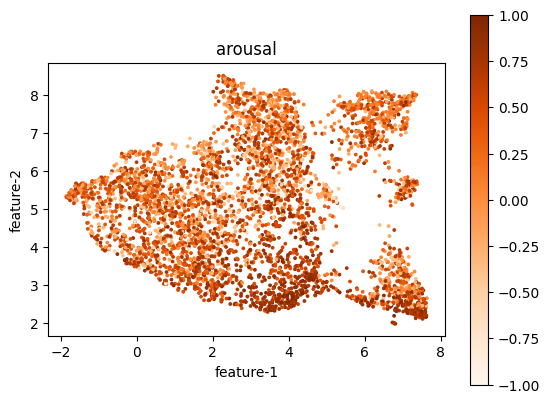

In [20]:
finetuned_fig = plot_tokens(tokens, targets, 50)

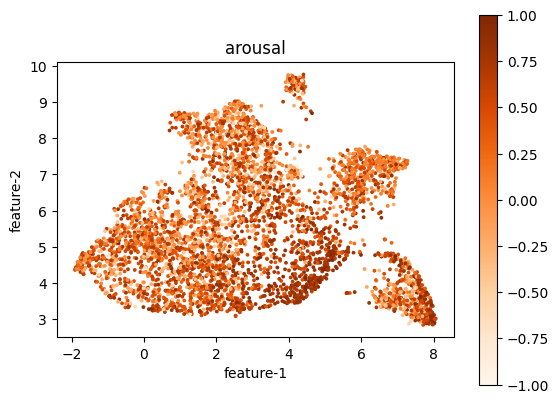

In [21]:
# wandb.init(project='AffectNet-vit', id='kde_aro_230403', resume='must')
finetuned_fig = plot_tokens(tokens, targets, 50)
wandb.log({'finetuned-plot': wandb.Image(finetuned_fig)})

In [22]:
non_finetuned_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                                num_labels=1,
                                                                problem_type='regression')

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


100%|██████████| 4500/4500 [02:43<00:00, 27.58it/s]


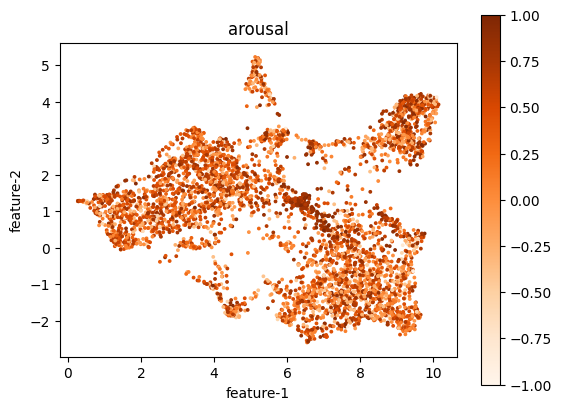

In [23]:
tokens, targets = CLE_tokens(non_finetuned_model.to(device),
                             feature_extractor,
                             val_dataset,
                             device)
non_finetuned_plot = plot_tokens(tokens, targets, 50)
wandb.log({'non-finetuned-plot': wandb.Image(non_finetuned_plot)})

In [24]:
wandb.finish()

eval/loss,█▇▅▃▃▃▂▂▂▂▂▂▁▁▁▂▂
eval/mse,▆█▇▃▅▆▃▃▂▄▄▃▁▁▂▃▅
eval/rmse,▆█▇▃▅▆▃▃▂▄▅▃▁▁▂▄▅
eval/runtime,█▁▇▁▁▁▁▁▁▁▁▁▄▁▁▁▁
eval/samples_per_second,▁█▁█████████▃████
eval/steps_per_second,▁█▁█████████▃████
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,███▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,██▇▆▅▅▄▄▄▃▃▃▃▃▃▃▃▂▃▂▃▂▃▂▂▂▂▂▂▃▂▂▂▁
train/mse,▃▄█▂▅▂▄▁▄▆▁▇▃▆▁▃█▂▄▃▄▁▄▅▂▆▂▇▃▅▆▂▂▃▂▂▁▅▃▆
